<a href="https://colab.research.google.com/github/adwaitthangan-algo/Conversation-Flow-NLP-/blob/main/INTENT_RECOGNITION_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd

In [2]:
df = pd.read_excel(r'/content/Phrases DataSet.xlsx')
df

,PHRASES,LABELS
0,"""Please show me the menu.""",0
1,"""I'd like to view the menu.""",0
2,"""Could you bring me the menu?""",0
3,"""May I have a look at the menu?""",0
4,"""Can you show me the menu options?""",0
...,...,...
195,"""The product was damaged, and I need to compla...",3
196,"""I had an issue with the delivery service and ...",3
197,"""I am not satisfied with the product and need ...",3
198,"""I want to address a problem with the recent c...",3


In [3]:
#Add the new column which gives a unique type of phrase to each of these labels

df['label_num'] = df['LABELS'].map({
    0 : 'Menu',
    1 : 'Order',
    2 : 'Cancel',
    3 : 'Complaint'
})

#checking the results
df.head(5)

,PHRASES,LABELS,label_num
0,"""Please show me the menu.""",0,Menu
1,"""I'd like to view the menu.""",0,Menu
2,"""Could you bring me the menu?""",0,Menu
3,"""May I have a look at the menu?""",0,Menu
4,"""Can you show me the menu options?""",0,Menu


In [4]:
# Shuffle the rows by shuffling the index
shuffled_df = df.sample(frac=1).reset_index(drop=True)

# Save the shuffled DataFrame to a new file (optional)
shuffled_df.to_csv('shuffled_dataset.csv', index=False)

shuffled_df

,PHRASES,LABELS,label_num
0,"""Please let me see the menu items.""",0,Menu
1,"""I am writing to complain about the handling o...",3,Complaint
2,"""I need to cancel the delivery I ordered.""",2,Cancel
3,"""Cancel my food order, thanks.""",2,Cancel
4,"""Show me the menu for today.""",0,Menu
...,...,...,...
195,"""Could I have a menu, please?""",0,Menu
196,"""Is it possible to cancel the meal order?""",2,Cancel
197,"""Can I get the fried rice with chicken?""",1,Order
198,"""Please show me the current menu.""",0,Menu


In [5]:
X = shuffled_df.PHRASES
Y = shuffled_df.LABELS

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    Y,
    test_size=0.2, # 20% samples will go to test dataset
    random_state=42
)

In [6]:
class BertLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(BertLayer, self).__init__(**kwargs)
        self.bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", trainable=False)
        self.bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3", trainable=False)

    def call(self, inputs):
        preprocessed_text = self.bert_preprocess(inputs)
        return self.bert_encoder(preprocessed_text)['pooled_output']

# Define input layer
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')

# Apply custom BERT layer
outputs = BertLayer()(text_input)

# Converted into vector using BERT
outputs

<KerasTensor shape=(None, 768), dtype=float32, sparse=False, name=keras_tensor>

In [7]:
# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs)
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

In [8]:
# Define the model
model = tf.keras.Model(inputs=text_input, outputs=l)

# Print model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text (InputLayer)                    │ (None)                      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bert_layer (BertLayer)               │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 1)                   │             769 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 769 (3.00 KB)

 Trainable params: 769 (3.00 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [10]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 98s 17s/step - accuracy: 0.2188 - loss: 0.1551 - precision: 0.7623 - recall: 0.7424
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 80s 16s/step - accuracy: 0.2686 - loss: -0.9797 - precision: 0.7769 - recall: 1.0000
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 83s 16s/step - accuracy: 0.2881 - loss: -1.6645 - precision: 0.7530 - recall: 1.0000
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 81s 16s/step - accuracy: 0.2321 - loss: -2.6709 - precision: 0.7504 - recall: 1.0000
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 83s 16s/step - accuracy: 0.2872 - loss: -3.1272 - precision: 0.7487 - recall: 1.0000
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 82s 16s/step - accuracy: 0.2278 - loss: -3.6934 - precision: 0.7335 - recall: 1.0000
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 80s 16s/step - accuracy: 0.2603 - loss: -4.9177 - precision: 0.7704 - recall: 1.0000
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 84s 17s/step - accuracy: 0.2625 - loss: -4.9812 - precision: 0.7600 - recall: 1.0000
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━

In [11]:
model.evaluate(X_test, y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 33s 7s/step - accuracy: 0.2229 - loss: -9.4871 - precision: 0.7604 - recall: 1.0000


[-9.305389404296875, 0.22499999403953552, 0.75, 1.0]

In [12]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

2/2 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step


In [13]:
import numpy as np

In [14]:
y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [15]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm

array([[ 0, 10,  0,  0],
       [ 0,  9,  0,  0],
       [ 0,  7,  0,  0],
       [ 0, 14,  0,  0]])

Text(50.722222222222214, 0.5, 'Truth')

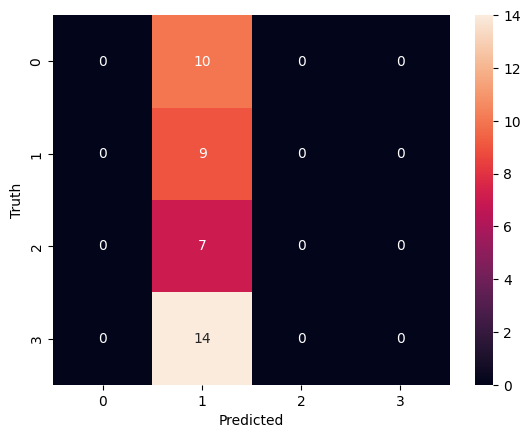

In [16]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [17]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.23      1.00      0.37         9
           2       0.00      0.00      0.00         7
           3       0.00      0.00      0.00        14

    accuracy                           0.23        40
   macro avg       0.06      0.25      0.09        40
weighted avg       0.05      0.23      0.08        40



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
